In [1]:
import  numpy as np
from scipy.integrate import quad
from Constants import c, fc, GeVtocm2
import matplotlib.pyplot as plt
from CrossSections import Transfer_Sigma_Low_Energy, Transfer_sigma

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

gp = 0.6
mZp = 0.02
mDM = 1
v_array = np.logspace(1, 3, 100)





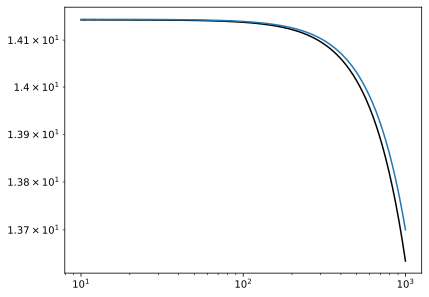

In [8]:


crossSection_array = [Transfer_Sigma_Low_Energy(v/c, gp, mZp, mDM) for v in v_array]
crossSection_array_3 = [Transfer_sigma(v/c) for v in v_array]


plt.plot(v_array, crossSection_array, 'k')
plt.plot(v_array, crossSection_array_3)


plt.xscale('log')
plt.yscale('log')
plt.show()
